# Data Preparation

In [ ]:
!pip install imblearn


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import word_tokenize 
from IPython.display import display, Markdown, Latex
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import VotingClassifier,RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('dataset_penyisihan_bdc_2024.csv', delimiter=';')
len(df)

5000

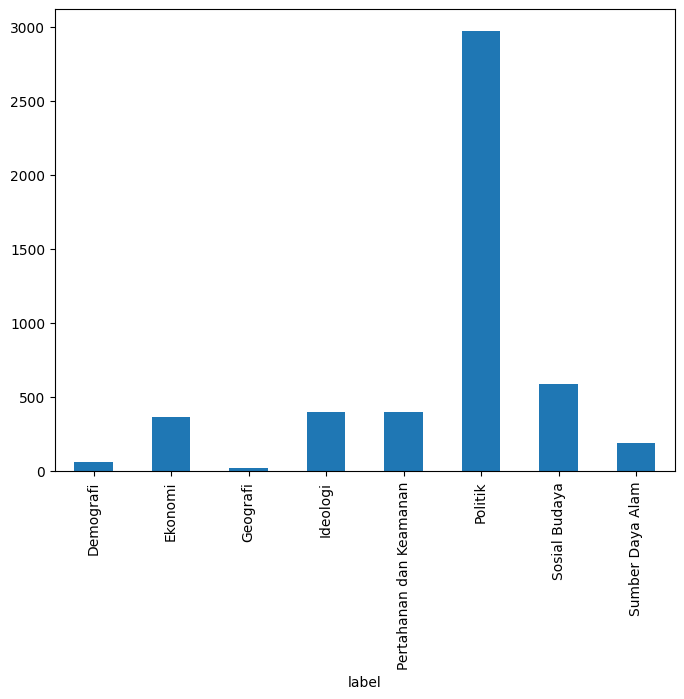

label
Demografi                    62
Ekonomi                     367
Geografi                     20
Ideologi                    400
Pertahanan dan Keamanan     400
Politik                    2972
Sosial Budaya               587
Sumber Daya Alam            192
Name: text, dtype: int64

In [ ]:
df.columns = ['text', 'label']

fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()
df.groupby('label').text.count()

# Duplicate Value Handling

In [ ]:
# df[df.duplicated()].groupby('label').size()
df = df.drop_duplicates('text').reset_index(drop=True)
df.duplicated('text').sum()


0

# Missing Value Handling

In [ ]:
empty_labels = df['label'] == ''
empty_labels.sum()

0

# Clean Up Text

In [ ]:
f = open("indonesian-stopwords.txt", "r")
stopword_list = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_list.append(line_list[0])
f.close()

len(stopword_list)

760

In [ ]:
def remove_https(text):
    pattern = r'http[s]?://\S+'
    # Replace matched URLs with an empty string
    cleaned_text = re.sub(pattern, '', text)
    # Remove any extra spaces created by the removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def remove_at_equals_words(text):
    # Regular expression to match words that start with "@" and end with "="
    pattern = r'@[0-9A-Za-z/+=]*='
    # Replace matched patterns with an empty string
    cleaned_text = re.sub(pattern, '', text)
    # Remove any extra spaces created by the removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def remove_short_words(text):
    # Regular expression to match words with less than four letters
    pattern = r'\b\w{1,3}\b'
    # Replace matched words with an empty string
    cleaned_text = re.sub(pattern, '', text)
    # Remove extra spaces created by the removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def remove_re_brackets(text):
    # Regular expression to match patterns that start with "[RE" and end with "]"
    pattern = r'\[RE[^\]]*\]'
    # Replace matched patterns with an empty string
    cleaned_text = re.sub(pattern, '', text)
    # Remove any extra spaces created by the removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def remove_hashtags(text):
    # Define the regex pattern to match hashtags
    pattern = r'#\S+'
    # Use re.sub to replace the matched pattern with an empty string
    result = re.sub(pattern, '', text)
    return result

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [ ]:
def transform_text(text, stopword_list):
    #tweet = remove_hashtags(text)
    tweet = remove_https(text)
    tweet = remove_at_equals_words(tweet)
    tweet = remove_re_brackets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = remove_short_words(tweet)
    # Step 2: transform into lowercase
    tweet = tweet.lower()
    # Step 3: Split different elements into words
    tweet = tweet.split()
    # Step 4: Remove duplicate words in a tweet
    tweet = list(set(tweet))
    # Step 5: stemming
    filtered_tweet_tokens = [word for word in tweet if not word in stopword_list]
    filtered_tweet_tokens = ' '.join(filtered_tweet_tokens)
    return filtered_tweet_tokens

In [ ]:
def clean_text(dataframe, column):
    corpus = []
    for i in range(0, dataframe.shape[0]):
        filtered_tweet_tokens = transform_text(dataframe[column][i], stopword_list)
        corpus.append(filtered_tweet_tokens)
    return corpus

In [ ]:
cleaned_text_array = clean_text(df, "text")

# Create Bag of Words

In [ ]:
# Just check the max_features by using the code cell below
# There are 11.846 words from tokenization. Keep the 10.000 most relevant words.
# CEK SECARA DINAMIS SAJA NILAI max_features-nya
cv = CountVectorizer(max_features=2000)
X = cv.fit_transform(cleaned_text_array).toarray()
y = df.iloc[:, -1].values

# Split Training set and Test set

In [ ]:
#x = df.drop(columns='label')
#y = df["label"]
# (train 60%, validation 20%), test 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)


# Undersampling

In [ ]:
#Undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_undersampled, y_train_undersampled = undersampler.fit_resample(x_train, y_train)
# Print all class count
pd.Series(y_train_undersampled).value_counts()

Demografi                  14
Ekonomi                    14
Geografi                   14
Ideologi                   14
Pertahanan dan Keamanan    14
Politik                    14
Sosial Budaya              14
Sumber Daya Alam           14
Name: count, dtype: int64

# Oversampling

In [ ]:
# Oversampling
oversampler = RandomOverSampler(sampling_strategy = 'auto', random_state = 42)
x_train_oversampled, y_train_oversampled = oversampler.fit_resample(x_train, y_train)
# Print all class count
pd.Series(y_train_oversampled).value_counts()

Sosial Budaya              1759
Pertahanan dan Keamanan    1759
Ekonomi                    1759
Politik                    1759
Ideologi                   1759
Sumber Daya Alam           1759
Geografi                   1759
Demografi                  1759
Name: count, dtype: int64

# Build a model (terserah mau apa)

In [ ]:
# classifier = SVC()
#classifier = SVC(kernel = 'rbf', random_state = 42)
svm_clf = SVC(kernel='linear', probability=True)
gb_clf = GradientBoostingClassifier()
knn_clf = KNeighborsClassifier()

estimators = [
    ('SVM', svm_clf),
    ('GradientBoosting', gb_clf),
    ('KNN', knn_clf)
]


# Create the ensemble classifier
classifier = VotingClassifier(estimators=estimators, voting='soft')
classifier.fit(x_train, y_train)

# Define a pipeline with ensemble classifier
pipeline = Pipeline([
   ('classifier', classifier)
])

# Hyperparameter tuning (example with GridSearchCV)
param_grid = {
    'classifier__SVM__C': [0.1, 1, 10],
    'classifier__GradientBoosting__n_estimators': [100, 200],
    'classifier__KNN__n_neighbors': [3, 5, 7]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall_macro')
grid_search.fit(x_train, y_train)

# Best model
best_model = grid_search.best_estimator_


# Evaluate that model

## Predicting Test set

In [ ]:
y_pred = classifier.predict(x_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
recall = recall_score(y_test, y_pred, average='macro')
print("Best Recall Score:", recall)

[['Politik' 'Politik']
 ['Politik' 'Politik']
 ['Politik' 'Politik']
 ...
 ['Politik' 'Politik']
 ['Politik' 'Politik']
 ['Politik' 'Ekonomi']]
Best Recall Score: 0.37816405556068783


## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[  1   0   0   0   0   7   0   0]
 [  0  31   0   0   1  26   1   0]
 [  0   0   1   0   0   3   0   0]
 [  0   0   1  28   1  41   0   1]
 [  1   0   0   1  27  34   1   0]
 [  0   4   0   2   4 579   4   1]
 [  2   1   0   0   1  61  14   0]
 [  0   2   0   0   0  29   0   6]]
                         precision    recall  f1-score   support

              Demografi       0.25      0.12      0.17         8
                Ekonomi       0.82      0.53      0.64        59
               Geografi       0.50      0.25      0.33         4
               Ideologi       0.90      0.39      0.54        72
Pertahanan dan Keamanan       0.79      0.42      0.55        64
                Politik       0.74      0.97      0.84       594
          Sosial Budaya       0.70      0.18      0.28        79
       Sumber Daya Alam       0.75      0.16      0.27        37

               accuracy                           0.75       917
              macro avg       0.68      0.38      0.45       917
  

# Write Predictions to CSV

In [ ]:
df_labeled = pd.read_csv('template_jawaban_penyisihan_bdc_2024.csv', delimiter=';')
df_labeled['Kelas'] = new_y_pred_unlabeled

df_labeled.to_csv('SD2024040000354.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=312f3f4a-2421-48f9-8185-adb230e57568' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>